# Phosphofructokinase (PFK)

For the construction of the PFK `EnzymeModule`, the following assumptions were made:

1. The enzyme is a homotetramer.
2. The enzyme binding and catalyzation of substrates occurs in an ordered sequential mechanism.
3. The mechanism of allosteric regulation is based on the Monod-Wyman-Changeux (MWC) model for allosteric transitions of homoproteins.

\\(\text{[PFK]}_{total} = 33 nM = 0.033 \mu M = 0.000033 mM\\).

Based on “Network-Level Allosteric Effects Are Elucidated by Detailing How Ligand-Binding Events Modulate Utilization of Catalytic Potentials."

__URL:__ https://doi.org/10.1371/journal.pcbi.1006356

In [1]:
from operator import attrgetter
from os import path

from cobra import DictList

import matplotlib.pyplot as plt

from scipy import optimize

import sympy as sym

import mass
from mass import MassMetabolite, Simulation, UnitDefinition
from mass.enzyme_modules import EnzymeModule
from mass.io import json, sbml
from mass.util import Keq2k, k2Keq, strip_time, qcqa_model

print("MASSpy version: " + mass.__version__)

MASSpy version: 0.1.1


## Load Models

In [2]:
glycolysis = json.load_json_model(
    filename=path.abspath(path.join("data", "models", "JSON", "Glycolysis.json")))

## Module Construction

In [3]:
PFK = EnzymeModule("PFK", name="Phosphofructokinase",
                   subsystem="Glycolysis")

### Metabolites
#### Ligands

In [4]:
f6p_c = MassMetabolite(
    "f6p_c",
    name="D-Fructose 6-phosphate",
    formula="C6H11O9P",
    charge=-2,
    compartment="c")
fdp_c = MassMetabolite(
    "fdp_c",
    name="D-Fructose 1,6-bisphosphate",
    formula="C6H10O12P2",
    charge=-4,
    compartment="c")
atp_c = MassMetabolite(
    "atp_c",
    name="ATP",
    formula="C10H12N5O13P3",
    charge=-4,
    compartment="c")
adp_c = MassMetabolite(
    "adp_c",
    name="ADP",
    formula="C10H12N5O10P2",
    charge=-3,
    compartment="c")
amp_c = MassMetabolite(
    "amp_c",
    name="AMP",
    formula="C10H12N5O7P",
    charge=-2,
    compartment="c")
h_c = MassMetabolite(
    "h_c",
    name="H+",
    formula="H",
    charge=1,
    compartment="c")

PFK.add_metabolites([f6p_c, fdp_c, atp_c, adp_c, amp_c, h_c])

PFK.enzyme_module_ligands_categorized =  {
    "substrates": f6p_c,
    "cofactors": atp_c,
    "activators": amp_c,
    "inhibitors": atp_c,
    "products": [fdp_c, adp_c, h_c]}

# Access categorized attribute for ligands and print
for group in PFK.enzyme_module_ligands_categorized:
    print("{0}: {1}".format(
        group.id, str(sorted([m.id for m in group.members]))))

substrates: ['f6p_c']
cofactors: ['atp_c']
activators: ['amp_c']
inhibitors: ['atp_c']
products: ['adp_c', 'fdp_c', 'h_c']


#### EnzymeModuleForms

In [5]:
# Number of identical subunits
n_subunits = 4

for i in range(n_subunits + 1):
    # Make enzyme module forms per number of bound activators (Up to 4 Total)
    PFK.make_enzyme_module_form(
        "pfk_R{0:d}_c".format(i), 
        name="Automatic", 
        categories="Active",
        bound_metabolites={amp_c: i},
        compartment="c");

    PFK.make_enzyme_module_form(
        "pfk_R{0:d}_A_c".format(i), 
        name="Automatic", 
        categories="Active",
        bound_metabolites={atp_c: 1, amp_c: i},
        compartment="c");
    
    PFK.make_enzyme_module_form(
        "pfk_R{0:d}_AF_c".format(i), 
        name="Automatic", 
        categories="Active",
        bound_metabolites={atp_c: 1, f6p_c: 1, amp_c: i},
        compartment="c");

    # Make enzyme module forms per number of bound inhibitors (Up to 4 Total)
    PFK.make_enzyme_module_form(
        "pfk_T{0:d}_c".format(i), 
        name="Automatic", 
        categories="Inhibited",
        bound_metabolites={atp_c: i},
        compartment="c");
    
# Access categorized attribute for enzyme module forms and print
for group in PFK.enzyme_module_forms_categorized:
    print("{0}: {1}\n".format(
        group.id, str(sorted([m.id for m in group.members]))))

Active: ['pfk_R0_AF_c', 'pfk_R0_A_c', 'pfk_R0_c', 'pfk_R1_AF_c', 'pfk_R1_A_c', 'pfk_R1_c', 'pfk_R2_AF_c', 'pfk_R2_A_c', 'pfk_R2_c', 'pfk_R3_AF_c', 'pfk_R3_A_c', 'pfk_R3_c', 'pfk_R4_AF_c', 'pfk_R4_A_c', 'pfk_R4_c']

Inhibited: ['pfk_T0_c', 'pfk_T1_c', 'pfk_T2_c', 'pfk_T3_c', 'pfk_T4_c']



### Reactions
#### EnzymeModuleReactions

In [6]:
for i in range(n_subunits + 1):
    # Make reactions for enzyme-ligand binding and catalytzation per number of bound activators (Up to 4 Total)
    PFK.make_enzyme_module_reaction(
        "PFK_R{0:d}1".format(i), 
        name="Automatic",
        subsystem="Glycolysis",
        reversible=True,
        categories="atp_c_binding",
        metabolites_to_add={
            "pfk_R{0:d}_c".format(i): -1, 
            "atp_c": -1, 
            "pfk_R{0:d}_A_c".format(i): 1})
    
    PFK.make_enzyme_module_reaction(
        "PFK_R{0:d}2".format(i), 
        name="Automatic",
        subsystem="Glycolysis",
        reversible=True,
        categories="f6p_c_binding",
        metabolites_to_add={
            "pfk_R{0:d}_A_c".format(i): -1, 
            "f6p_c": -1, 
            "pfk_R{0:d}_AF_c".format(i): 1})
    
    PFK.make_enzyme_module_reaction(
        "PFK_R{0:d}3".format(i), 
        name="Automatic",
        subsystem="Glycolysis",
        reversible=False,
        categories="catalyzation",
        metabolites_to_add={
            "pfk_R{0:d}_AF_c".format(i): -1, 
            "pfk_R{0:d}_c".format(i): 1, 
            "adp_c": 1, 
            "fdp_c": 1,
            "h_c": 1})
    
    if i < n_subunits:
        # Make enzyme reactions for enzyme-activator binding
        PFK.make_enzyme_module_reaction(
            "PFK_R{0:d}0".format(i + 1), 
            name="Automatic",
            subsystem="Glycolysis",
            reversible=True,
            categories="amp_c_activation",
            metabolites_to_add={
                "pfk_R{0:d}_c".format(i): -1, 
                "amp_c": -1, 
                "pfk_R{0:d}_c".format(i + 1): 1})

        # Make enzyme reactions for enzyme-inhibitor binding
        PFK.make_enzyme_module_reaction(
            "PFK_T{0:d}".format(i + 1), 
            name="Automatic",
            subsystem="Glycolysis",
            reversible=True,
            categories="atp_c_inhibition",
            metabolites_to_add={
                "pfk_T{0:d}_c".format(i): -1, 
                "atp_c": -1, 
                "pfk_T{0:d}_c".format(i + 1): 1})

# Make reaction representing enzyme transition from R to T state
PFK.make_enzyme_module_reaction(
    "PFK_L",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="rt_transition",
    metabolites_to_add={
        "pfk_R0_c": -1, 
        "pfk_T0_c": 1});

# Access categorized attribute for enzyme module reactions and print
for group in PFK.enzyme_module_reactions_categorized:
    print("{0}: {1}\n".format(
        group.id, str(sorted([m.id for m in group.members]))))

atp_c_binding: ['PFK_R01', 'PFK_R11', 'PFK_R21', 'PFK_R31', 'PFK_R41']

f6p_c_binding: ['PFK_R02', 'PFK_R12', 'PFK_R22', 'PFK_R32', 'PFK_R42']

catalyzation: ['PFK_R03', 'PFK_R13', 'PFK_R23', 'PFK_R33', 'PFK_R43']

amp_c_activation: ['PFK_R10', 'PFK_R20', 'PFK_R30', 'PFK_R40']

atp_c_inhibition: ['PFK_T1', 'PFK_T2', 'PFK_T3', 'PFK_T4']

rt_transition: ['PFK_L']



#### Unify Rate Parameters

In [7]:
abbreviations = ["A", "F", "I", "ACT"]
ligands = [atp_c, f6p_c, atp_c, amp_c]

for met, unified_id in zip(ligands, abbreviations):
    category = {"A": "binding",
                "F": "binding",
                "I": "inhibition",
                "ACT": "activation"}[unified_id]
    group = PFK.enzyme_module_reactions_categorized.get_by_id(
        "_".join((met.id, category)))
    reactions = sorted(group.members, key=attrgetter("id"))
    PFK.unify_rate_parameters(reactions, unified_id,
                              rate_type=2, enzyme_prefix=True)
    # Add the coefficients to make symmetry model rate laws for activation and inhibition 
    if unified_id in ["I", "ACT"]:
        for i, reaction in enumerate(reactions):
            custom_rate = str(strip_time((reaction.rate)))
            custom_rate = custom_rate.replace(
                "kf_", "{0:d}*kf_".format(n_subunits - i))
            custom_rate = custom_rate.replace(
                "kr_", "{0:d}*kr_".format(i + 1))
            PFK.add_custom_rate(reaction, custom_rate)
            
PFK.unify_rate_parameters(
    PFK.enzyme_module_reactions_categorized.get_by_id("catalyzation").members,
    "PFK")
# Update rate laws to be in terms of kf and Keq
PFK.custom_rates.update(k2Keq(PFK.custom_rates))

# Access categorized attribute for enzyme module reactions and print
for group in PFK.enzyme_module_reactions_categorized:
    header = "Category: " + group.id
    print("\n" + header + "\n" + "-" * len(header))
    for reaction in sorted(group.members, key=attrgetter("id")):
        print(reaction.id + ": " + str(reaction.rate))


Category: atp_c_binding
-----------------------
PFK_R01: kf_PFK_A*(atp_c(t)*pfk_R0_c(t) - pfk_R0_A_c(t)/Keq_PFK_A)
PFK_R11: kf_PFK_A*(atp_c(t)*pfk_R1_c(t) - pfk_R1_A_c(t)/Keq_PFK_A)
PFK_R21: kf_PFK_A*(atp_c(t)*pfk_R2_c(t) - pfk_R2_A_c(t)/Keq_PFK_A)
PFK_R31: kf_PFK_A*(atp_c(t)*pfk_R3_c(t) - pfk_R3_A_c(t)/Keq_PFK_A)
PFK_R41: kf_PFK_A*(atp_c(t)*pfk_R4_c(t) - pfk_R4_A_c(t)/Keq_PFK_A)

Category: f6p_c_binding
-----------------------
PFK_R02: kf_PFK_F*(f6p_c(t)*pfk_R0_A_c(t) - pfk_R0_AF_c(t)/Keq_PFK_F)
PFK_R12: kf_PFK_F*(f6p_c(t)*pfk_R1_A_c(t) - pfk_R1_AF_c(t)/Keq_PFK_F)
PFK_R22: kf_PFK_F*(f6p_c(t)*pfk_R2_A_c(t) - pfk_R2_AF_c(t)/Keq_PFK_F)
PFK_R32: kf_PFK_F*(f6p_c(t)*pfk_R3_A_c(t) - pfk_R3_AF_c(t)/Keq_PFK_F)
PFK_R42: kf_PFK_F*(f6p_c(t)*pfk_R4_A_c(t) - pfk_R4_AF_c(t)/Keq_PFK_F)

Category: catalyzation
----------------------
PFK_R03: kf_PFK*pfk_R0_AF_c(t)
PFK_R13: kf_PFK*pfk_R1_AF_c(t)
PFK_R23: kf_PFK*pfk_R2_AF_c(t)
PFK_R33: kf_PFK*pfk_R3_AF_c(t)
PFK_R43: kf_PFK*pfk_R4_AF_c(t)

Category: amp_

### Compartments

In [8]:
PFK.compartments = {"c": "Cytosol"}

## Steady State Concentrations and Rate Constants
### Rate Equation

In [9]:
catalyzation_rxns = PFK.enzyme_module_reactions_categorized.get_by_id(
    "catalyzation").members
PFK.make_enzyme_rate_equation(
    catalyzation_rxns,
    use_rates=True, update_enzyme=True)

print(PFK.enzyme_rate_equation)

kf_PFK*(pfk_R0_AF_c(t) + pfk_R1_AF_c(t) + pfk_R2_AF_c(t) + pfk_R3_AF_c(t) + pfk_R4_AF_c(t))


### Solve steady state concentrations symbolically

In [10]:
ode_dict = {
    sym.Symbol(enzyme_module_form.id): sym.Eq(strip_time(enzyme_module_form.ode), 0)
    for enzyme_module_form in PFK.enzyme_module_forms}

# Get enzyme module forms
enzyme_module_forms = PFK.enzyme_module_forms.copy()
# Reverse list for increased performance (due to symmetry assumption)
# by solving for the most activated/inhibitors bound first.
enzyme_module_forms.reverse()

enzyme_solutions = {}
for enzyme_module_form in enzyme_module_forms:
    # Skip dependent variable
    if "pfk_R0_c" == str(enzyme_module_form):
        continue
    enzyme_module_form = sym.Symbol(enzyme_module_form.id)
    # Susbtitute in previous solutions and solve for the enzyme module form, 
    equation = ode_dict[enzyme_module_form]
    sol = sym.solveset(equation.subs(enzyme_solutions),
                       enzyme_module_form)
    enzyme_solutions[enzyme_module_form] = list(sol)[0]
    # Update the dictionary of solutions with the solutions
    enzyme_solutions.update({
        enzyme_module_form: sol.subs(enzyme_solutions) 
        for enzyme_module_form, sol in enzyme_solutions.items()})
    
enzyme_rate_equation = strip_time(PFK.enzyme_rate_error(False))

# Solve for last unknown concentration symbolically
sol = sym.solveset(enzyme_rate_equation.subs(enzyme_solutions),
                   "pfk_R0_c")

# Update solution dictionary with the new solution
enzyme_solutions[sym.Symbol("pfk_R0_c")] = list(sol)[0]

# Update solutions with free variable solutions
enzyme_solutions = {
    enzyme_module_form: sym.simplify(solution.subs(enzyme_solutions))
    for enzyme_module_form, solution in enzyme_solutions.items()}

#### Numerical Values

In [11]:
numerical_values = {}

# Get ligand IDs and parameter IDs
ligand_ids = sorted([str(ligand) for ligand in PFK.enzyme_module_ligands])
parameter_ids = ["_".join((PFK.id, abbrev)) for abbrev in abbreviations + ["L"]]

# Get the steady state flux value and add to numerical values
PFK.enzyme_rate = glycolysis.reactions.get_by_id(PFK.id).steady_state_flux
numerical_values.update({PFK.enzyme_flux_symbol_str: PFK.enzyme_rate})

# Get the steady state concentration values and add to numerical values
initial_conditions = {
    str(ligand): glycolysis.initial_conditions[glycolysis.metabolites.get_by_id(ligand)]
    for ligand in ligand_ids}
numerical_values.update(initial_conditions)

# Define parameter values and add to numerical values
# Because of the QEA, invert dissociation constants for Keq
parameter_values = {
    "Keq_" + parameter_id: value 
    for parameter_id, value in zip(parameter_ids, [1/0.068, 1/0.1, 1/0.1, 1/0.033, 0.0011])}
numerical_values.update(parameter_values)

# Display numerical values
print("\nNumerical Values\n----------------")
for k, v in numerical_values.items():
    print("{0} = {1}".format(k, v))


Numerical Values
----------------
v_PFK = 1.12
adp_c = 0.29
amp_c = 0.0867281
atp_c = 1.6
f6p_c = 0.0198
fdp_c = 0.0146
h_c = 8.99757e-05
Keq_PFK_A = 14.705882352941176
Keq_PFK_F = 10.0
Keq_PFK_I = 10.0
Keq_PFK_ACT = 30.3030303030303
Keq_PFK_L = 0.0011


### Calculate Steady State Concentrations

#### Set total enzyme concentration

In [12]:
PFK.enzyme_concentration_total = 33e-6

#### Determine rate constants

In [13]:
enzyme_solutions = {
    enzyme_module_form: sym.simplify(solution.subs(numerical_values))
    for enzyme_module_form, solution in enzyme_solutions.items()}

args = set()
for sol in enzyme_solutions.values():
    args.update(sol.atoms(sym.Symbol))
    
enzyme_total_constraint = abs(
    strip_time(PFK.enzyme_concentration_total_error(use_values=False)))

# Substitute value for enzyme concentration total
enzyme_total_constraint = enzyme_total_constraint.subs({
    PFK.enzyme_total_symbol_str: PFK.enzyme_concentration_total})
# Substitute solutions into constraint and simplify
enzyme_total_constraint = sym.simplify(
    enzyme_total_constraint.subs(enzyme_solutions))

# Create a sorted tuple of the arguments to ensure the input format does not change
args = tuple(sorted([str(arg) for arg in list(args)]))
# Create the objective function as a lambda function
objective_function = lambda x: sym.lambdify(args, enzyme_total_constraint)(*x)

# Set arguments for minimization 
initial_guess = [3.07e5, 1.25e5, 5.05e5]
kf_bounds = ((1e3, 1e9), (1e3, 1e9), (1e3, 1e9))
constraints = (
    {"type": "eq", "fun": objective_function})
# Find a feasible solution
sol = optimize.minimize(
    objective_function, x0=initial_guess, method="trust-constr",
    bounds=kf_bounds,
    options={"gtol": 1e-12, "xtol": 1e-12, "maxiter": 1e4, "disp": True})

# Check whether optimzation was successful
print("\nOptimization Success: {0}".format(sol.success))
if sol.success:
    # Update the paramter values dictionary with the feasible solution
    parameter_values.update(
        dict(zip(args, [round(x) for x in sol.x])))
    print("Optimization Optimality: {0:.4e}".format(sol.optimality))
    print("Parameter Solutions: {:}".format(str({
        arg: parameter_values[arg] for arg in args})))
    # Plug solutions back into constraints for validation
    print("Concentration Error: {0:.4e}".format(
        enzyme_total_constraint.subs(parameter_values)))

`xtol` termination condition is satisfied.
Number of iterations: 91, function evaluations: 264, CG iterations: 112, optimality: 9.84e-12, constraint violation: 0.00e+00, execution time:  1.3 s.

Optimization Success: True
Optimization Optimality: 9.8428e-12
Parameter Solutions: {'kf_PFK': 949000, 'kf_PFK_A': 1087095, 'kf_PFK_F': 2460332}
Concentration Error: 4.3974e-12


#### Set initial conditions

In [14]:
# Add the activation, inhibition, and allosteric rate constants
for abbrev, value in zip(["I", "ACT", "L"], [1e6, 1e6, 1e6**2]):
    # Account for the enzyme prefix if used in the previous function
    to_join = ("kf", PFK.id, abbrev)
    param = "_".join(to_join)
    parameter_values.update({param: value})
    
# Substitute values into equations
initial_conditions.update({
    str(enzyme_module_form): float(sym.simplify(solution.subs(parameter_values)))
    for enzyme_module_form, solution in enzyme_solutions.items()})

# Set initial conditions
for met, concentration in initial_conditions.items():
    PFK.metabolites.get_by_id(str(met)).ic = concentration

for header, dictlist in zip(["Ligand", "\nEnzyme"], [PFK.enzyme_module_ligands, PFK.enzyme_module_forms]):
    header += " Concentrations"
    print("\n".join([header, "-" * len(header)]))
    for form in dictlist:
        ic = initial_conditions[form.id]
        print("{0} = {1}".format(form.id, ic))

Ligand Concentrations
---------------------
f6p_c = 0.0198
fdp_c = 0.0146
atp_c = 1.6
adp_c = 0.29
amp_c = 0.0867281
h_c = 8.99757e-05

Enzyme Concentrations
----------------------
pfk_R0_c = 1.0817448316365941e-08
pfk_R0_A_c = 1.6708761988387294e-07
pfk_R0_AF_c = 6.811193326245456e-09
pfk_T0_c = 1.1899193148002537e-11
pfk_R1_c = 1.1371839264565055e-07
pfk_R1_A_c = 1.7565080977030931e-06
pfk_R1_AF_c = 7.160264920217556e-08
pfk_T1_c = 7.615483614721626e-10
pfk_R2_c = 4.4829909678232944e-07
pfk_R2_A_c = 6.924482270381984e-06
pfk_R2_AF_c = 2.822709872850547e-07
pfk_T2_c = 1.82771606753319e-08
pfk_R3_c = 7.854571494070209e-07
pfk_R3_A_c = 1.213226648068516e-05
pfk_R3_AF_c = 4.945621497445849e-07
pfk_T3_c = 1.9495638053687361e-07
pfk_R4_c = 5.160697439355081e-07
pfk_R4_A_c = 7.97127591335993e-06
pfk_R4_AF_c = 3.249426937822979e-07
pfk_T4_c = 7.798255221474946e-07


### Set Parameters

In [15]:
# Update based on publication values
parameter_values.update({
    'kf_PFK': 307000.0,
    'kf_PFK_A': 125000.0,
    'kf_PFK_F': 505000.0})

# Add the custom parameters and values for kf and Keq to model
PFK.custom_parameters.update(parameter_values)
# PYK_L uses standard reaction parameters and not custom parameters
PFK_L = PFK.enzyme_module_reactions.PFK_L
PFK_L.kf = PFK.custom_parameters.pop(PFK_L.kf_str)
PFK_L.Keq = PFK.custom_parameters.pop(PFK_L.Keq_str)

### Units

In [16]:
concentration = UnitDefinition("mM", name="Millimolar", list_of_units=["millimole", "per_litre"])
time = UnitDefinition("hr", name="hour", list_of_units=["hour"])

PFK.add_units([concentration, time])

## QC model

In [17]:
qcqa_model(PFK, parameters=True, concentrations=True, 
           fluxes=False, superfluous=True, elemental=True)

╒══════════════════════════════════════════╕
│ MODEL ID: PFK                            │
│ SIMULATABLE: True                        │
│ PARAMETERS NUMERICALY CONSISTENT: True   │
╞══════════════════════════════════════════╡
╘══════════════════════════════════════════╛


#### Errors

In [18]:
print("Concentration Absolute Error: {0:.4e}".format(
    abs(PFK.enzyme_concentration_total_error(use_values=True))))

Concentration Absolute Error: 4.3974e-12


### Ordering of internal species and reactions

In [19]:
new_metabolite_order = [
    'f6p_c', 'fdp_c', 'amp_c', 'adp_c', 'atp_c', 'h_c',
    'pfk_R0_c', 'pfk_R0_A_c', 'pfk_R0_AF_c', 
    'pfk_R1_c', 'pfk_R1_A_c', 'pfk_R1_AF_c', 
    'pfk_R2_c', 'pfk_R2_A_c', 'pfk_R2_AF_c', 
    'pfk_R3_c', 'pfk_R3_A_c', 'pfk_R3_AF_c',
    'pfk_R4_c', 'pfk_R4_A_c', 'pfk_R4_AF_c',  
    'pfk_T0_c','pfk_T1_c', 'pfk_T2_c', 'pfk_T3_c', 'pfk_T4_c']

if len(PFK.metabolites) == len(new_metabolite_order):
    PFK.metabolites = DictList(
        PFK.metabolites.get_by_any(new_metabolite_order))
new_reaction_order = [
    "PFK_R01", 'PFK_R02', "PFK_R03", "PFK_R10", 
    "PFK_R11", "PFK_R12", "PFK_R13", "PFK_R20", 
    "PFK_R21", "PFK_R22", "PFK_R23", "PFK_R30", 
    "PFK_R31", "PFK_R32", "PFK_R33", "PFK_R40", 
    "PFK_R41", "PFK_R42", "PFK_R43", "PFK_L", 
    "PFK_T1", "PFK_T2", "PFK_T3", "PFK_T4"]

if len(PFK.reactions) == len(new_reaction_order):
    PFK.reactions = DictList(
        PFK.reactions.get_by_any(new_reaction_order))

## Simulation
### Merge model

In [20]:
# Merge the EnzymeModule into the MassModel
glycolysis_PFK = glycolysis.merge(PFK, inplace=False)
# Remove the PFK MassReaction
glycolysis_PFK.remove_reactions([
    glycolysis_PFK.reactions.get_by_id("PFK")])

### Simulate

Successfully loaded MassModel 'Glycolysis_PFK' into RoadRunner.


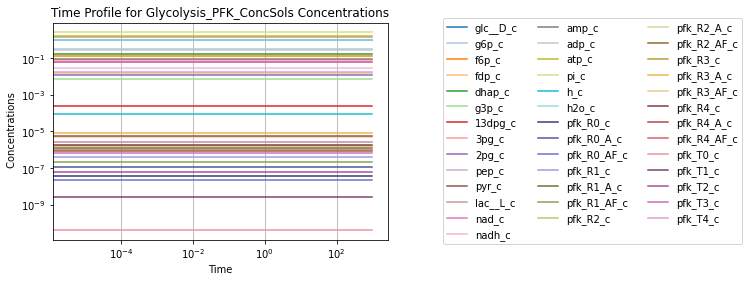

In [21]:
# Setup simulation object, ensure model is at steady state
sim = Simulation(glycolysis_PFK, verbose=True)

sim.find_steady_state(glycolysis_PFK, strategy="simulate",
                      update_values=True, tfinal=1e4)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(glycolysis_PFK,
                                  time=(0, 1e3, 1e4 + 1))
# Quickly render and display time profiles 
conc_sol.view_time_profile()

## Export

In [22]:
# Export model as JSON
json.save_json_model(
    mass_model=PFK,
    filename=path.abspath(path.join("data", "models", "JSON", PFK.id + ".json")))
# Export model as SBML
sbml.write_sbml_model(
    mass_model=PFK,
    filename=path.abspath(path.join("data", "models", "SBML", PFK.id + ".xml.zip")))

In [23]:
# Export value tables
from table_export import export_csv_files_for_models
export_csv_files_for_models([PFK], "for_pfk_notebook")

Exports finished for 1 models
